In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [161]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, 3,padding=1,bias=False),  
            nn.ReLU(),
            nn.BatchNorm2d(16),

            nn.Conv2d(16, 16, 3,padding=1,bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),

            nn.Conv2d(16, 64, 3,padding=1,bias=False), 
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        self.pool1 = nn.MaxPool2d(2,2)
        self.trans1 = nn.Sequential(
            nn.Conv2d(64, 8, 1,bias=False),
            nn.ReLU(),
        )
        self.conv2 =  nn.Sequential(
            nn.Conv2d(8, 16, 3,bias=False), 
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.1),

            nn.Conv2d(16, 16, 3,bias=False),  
            nn.ReLU(),
            nn.BatchNorm2d(16),
            # nn.Dropout2d(0.2),

            # nn.Conv2d(16, 16, 3,bias=False),  
            # nn.ReLU(),
            # nn.BatchNorm2d(16),
            # nn.Dropout2d(0.2), 
        )
        
        self.trans2 = nn.Sequential(
            nn.Conv2d(16, 16, 1,bias=False),
            nn.ReLU(),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 16, 3,bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            # nn.Dropout2d(0.2),     
        )
        self.gap = nn.Sequential(
            nn.AvgPool2d(6)
        )
        self.fc = nn.Linear(16,10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.trans1(x)
        x = self.conv2(x)
        x = self.trans2(x)
        x = self.conv3(x)
        x = self.gap(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        return F.log_softmax(x,dim=1)

In [162]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             144
              ReLU-2           [-1, 16, 28, 28]               0
       BatchNorm2d-3           [-1, 16, 28, 28]              32
            Conv2d-4           [-1, 16, 28, 28]           2,304
              ReLU-5           [-1, 16, 28, 28]               0
       BatchNorm2d-6           [-1, 16, 28, 28]              32
            Conv2d-7           [-1, 64, 28, 28]           9,216
              ReLU-8           [-1, 64, 28, 28]               0
       BatchNorm2d-9           [-1, 64, 28, 28]             128
        MaxPool2d-10           [-1, 64, 14, 14]               0
           Conv2d-11            [-1, 8, 14, 14]             512
             ReLU-12            [-1, 8, 14, 14]               0
           Conv2d-13           [-1, 16, 12, 12]           1,152
             ReLU-14           [-1, 16,

In [16]:


torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)



Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [132]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
    out_acc = 100.*correct / len(train_loader.dataset)
    out_loss = train_loss / len(train_loader)
    return out_acc,out_loss
    

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_acc,test_loss

In [160]:

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
for epoch in range(1, 20):
    train_acc,train_loss = train(model, device, train_loader, optimizer, epoch)
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    test_acc,test_loss = test(model, device, test_loader)
    test_acc_list.append(test_acc)
    test_loss_list.append(test_loss)

  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1051, Accuracy: 9699/10000 (97%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0549, Accuracy: 9838/10000 (98%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0510, Accuracy: 9855/10000 (99%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0464, Accuracy: 9863/10000 (99%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0421, Accuracy: 9869/10000 (99%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0355, Accuracy: 9890/10000 (99%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0391, Accuracy: 9879/10000 (99%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 9901/10000 (99%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0344, Accuracy: 9899/10000 (99%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0305, Accuracy: 9902/10000 (99%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0338, Accuracy: 9904/10000 (99%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9915/10000 (99%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Accuracy: 9916/10000 (99%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0369, Accuracy: 9882/10000 (99%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9921/10000 (99%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0317, Accuracy: 9912/10000 (99%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0330, Accuracy: 9899/10000 (99%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9921/10000 (99%)



loss=0.01829475723206997 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 39.08it/s]



Test set: Average loss: 0.0251, Accuracy: 9922/10000 (99%)



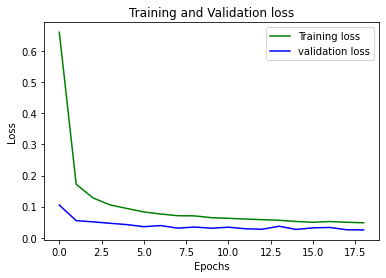

In [163]:
import matplotlib.pyplot as plt
% matplotlib inline
epochs = [x for x in range(0,19)]
plt.plot(epochs,train_loss_list, 'g', label='Training loss')
plt.plot(epochs,test_loss_list, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

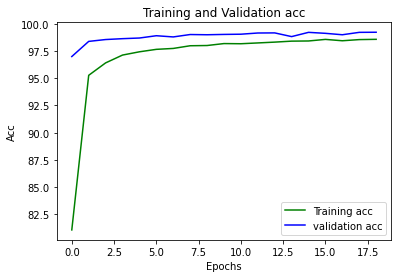

In [164]:
epochs = [x for x in range(0,19)]
plt.plot(epochs,train_acc_list, 'g', label='Training acc')
plt.plot(epochs,test_acc_list, 'b', label='validation acc')
plt.title('Training and Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()